### ITCR - Escuela de Computación
### Curso IC-6200 - Inteligencia Artificial
### Aprendizaje supervisado


### Projecto 3 parte 2:Análisis de emociones con redes neuronales recurrentes LSTM utilizando Pytorch.


Profesora: María Auxiliadora Mora

Estudiantes:
 1. Pablo Alberto Muñoz Hidalgo
 2. Luis Andrés Rojas Murillo

Entregables: Un archivo en Jupyter ( .IPYNB ). 

Modo de trabajo: En parejas.

---

Objetivo: El objetivo de este ejercicio de modelado es analizar el sentimiento en el texto utilizando la red neuronal LSTM recurrente de Pytorch. El objetivo principal es clasificar el texto de los tuits en cuatro clases que contienen más registros emocionales.

Problema: el problema es detectar emociones en el texto analizando tweets etiquetados con diferentes tipos de emociones. El objetivo es reconocer y reconocer las emociones presentes en las letras como el entusiasmo, el odio, la alegría y la tristeza. El conjunto de datos provisto contiene tweets etiquetados con el sentimiento expresado en ellos y tiene tres columnas que contienen la ID del tweet, el sentimiento (clase) presente en el tweet y el cuerpo del tweet. .

## Introducción

La clasificación de textos y el reconocimiento de entidades nombradas (Named Entity Recognition o NER por sus siglas en inglés) son técnicas fundamentales que constituyen el primer paso en muchas tareas de Procesamiento de lenguaje natural (NLP). NER, es un área de investigación relacionada a la extracción de información, que permite localizar y clasificar nombres de entidades que se encuentran en texto libre, en categorías comunmente organizaciones, lugares, tiempo, personas, entre otros. Ejemplo:

- El fundador de [Microsoft Corporation] (organización), [Bill Gates] (persona), comentó que se abrirán 1000 puestos de trabajo en la [Región Chorotega] (lugar) a partir del año 2022 (fecha).  

La clasificación de textos permite categorizar el contenido asociando este a un conjunto de etiquetas predefinidas o clases. Su uso más popular es el análisis de sentimientos. Ejemplo:

- En mi opinión, la película fue muy buena porque pudo dar a conocer a los espectadores cómo puede afectar una situación traumática a la mente humana. (Clase = 5 o excelente). 

Las redes neuronales recurrentes o RNN (Rumelhart et al., 1986, como se citó en LeCun et al., 2015) son una familia de redes neuronales para el procesamiento de secuencias de datos, las cuales en un tiempo t, reciben el estado anterior, es decir, su salida en el tiempo t podría usarse como insumo del procesamiento de la siguiente entrada, de modo que la información pueda propagarse a medida que la red pasa por la secuencia de entrada. Las redes Long Short-Term Memory (LSTM) son un tipo de red neuronal recurrente capaz de aprender dependencias a largo plazo.

El siguiente ejemplo implementa NER con una LSTM para etiquetar el rol que juegan las palabras en las oraciones. 


## Ejemplo

El sistema implementado en el código adjunto soluciona el problema de estimar el rol de una palabra en una frase, por ejempo roles como determinante (DET), nombre (NN) y verbo (V). 
Ejemplo para la frase:

- "El perro come manzana" la salida deberá ser: ["DET", "NN", "V", "NN"]). 

Este proceso se conoce en el procesamiento de lenguaje natural como "part of speech tagging (POS)".

Este es un ejemplo simple con datos introducidos en el código basado en [1].

Se realizarán los siguientes pasos

   * Definición de los ejemplos (codificados) 
   * Preprocesamiento de las palabras a clasificar
   * Definición del modelo
   * Instanciación del modelo, definición de la función de pérdida y del optimizador  
   * Entrenamiento de la red
   * Pruebas del modelo resultante con unos cuantos ejemplos.


In [269]:
# Bibliotecas requeridas
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import torch
import os
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import csv
import random
import numpy as np
import matplotlib.pyplot as plt
#Import scikit learn metrics
from sklearn import metrics
import re
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns



torch.manual_seed(1)

In [270]:
# Funciones utilitarias

def max_values(x):
    """
    Retorna el valor máximo y en índice o la posición del valor en un vector x.
    Parámetros: 
        x: vector con los datos. 
    Salida: 
        out: valor 
        inds: índice
    """
    out, inds = torch.max(x,dim=1)   
    return out, inds
    

    # Preparación de los datos 
def prepare_sequence(seq, to_ix):
    """
    Retorna un tensor con los indices del diccionario para cada palabras en una oración.
    Parámetros:
       seq: oración
       to_ix: diccionario de palabras.
    """
    idxs = [to_ix[w] for w in seq]
    return torch.tensor(idxs, dtype=torch.long)


#### Lectura del csv

In [271]:
#Delete tweets.csv
if os.path.exists("tweets.csv"):
    os.remove("tweets.csv")
else:
    print("The file does not exist")

with open('tweet_emotions.csv', 'r') as file:
    #Copy all contents to tweet.csv
    with open('tweets.csv', 'w') as file2:
        file2.write(file.read())
        file2.close()
    file.close()

with open('tweets.csv', 'r') as file:
    data = list(csv.reader(file))
    file.close()

with open('tweets.csv', 'w') as file:
    writer = csv.writer(file)
    writer.writerows(data)

##### Limpieza de los datos 

In [272]:

nltk.download('stopwords')
nltk.download('punkt')

def remove_stopwords_from_list(lst):
    stop_words = set(stopwords.words('english'))
    for i in lst:
        if len(i) == 3 and isinstance(i[2], str):
            tokens = word_tokenize(i[2])
            filtered_tokens = [word for word in tokens if word.lower() not in stop_words]
            i[2] = ' '.join(filtered_tokens)

    return lst



def check_if_exist_incomplete_data(lst):
    for i in lst:
        if len(i) != 3:
            #se elimina el registro
            lst.remove(i)
        else:
            pass
    return lst

def all_to_lower_case(lst):
    for i in lst:
        i[2] = i[2].lower()
    return lst



def clean_tweet_text(lst):
    for tweet in lst:
        # Eliminar menciones de usuarios (@usuario)
        tweet[2] = re.sub(r'@[A-Za-z0-9_]+', ' _at_ ', tweet[2])
        
        # Eliminar URLs (https://t.co/...)      
        tweet[2] = re.sub(r'https?://[A-Za-z0-9./]+', ' _url_ ', tweet[2])

        # Eliminar caracteres hashtag (#)
        tweet[2] = re.sub(r'#[A-Za-z0-9_]+', ' _hashtag_ ', tweet[2])

        # Eliminar caracteres de signos de puntuación (-), (*), (.), (,), (,), (!), (?), ("), ("), ('), (;), ((), ([), (=), (/), (\), (@), (#) y (:) uno a uno
    
        tweet[2] = re.sub(r'[-]', ' _gui_ ', tweet[2])
        tweet[2] = re.sub(r'[*]', ' _ast_ ', tweet[2])
        tweet[2] = re.sub(r'[.]', ' _dat_ ', tweet[2])
        tweet[2] = re.sub(r'[,]', ' _com_ ', tweet[2])
        tweet[2] = re.sub(r'[!]', ' _exc_ ', tweet[2])
        tweet[2] = re.sub(r'[?]', ' _int_ ', tweet[2])
        tweet[2] = re.sub(r'["]', ' _quo_ ', tweet[2])
        tweet[2] = re.sub(r"[']", " _clo_ ", tweet[2])
        tweet[2] = re.sub(r'[;]', ' _sem_ ', tweet[2])
        tweet[2] = re.sub(r'[(]', ' _par_ ', tweet[2])
        tweet[2] = re.sub(r'[)]', ' _par_ ', tweet[2])
        tweet[2] = re.sub(r'[\[]', ' _col_ ', tweet[2])
        tweet[2] = re.sub(r'[\]]', ' _col_ ', tweet[2])
        tweet[2] = re.sub(r'[=]', ' _eq_ ', tweet[2])
        tweet[2] = re.sub(r'[/]', ' _sla_ ', tweet[2])
        tweet[2] = re.sub(r'[\\]', ' _sla_ ', tweet[2])
        tweet[2] = re.sub(r'[@]', ' _at_ ', tweet[2])
        tweet[2] = re.sub(r'[#]', ' _hashtag2_ ', tweet[2])
        tweet[2] = re.sub(r'[:]', ' _col_ ', tweet[2])

    return lst

data = check_if_exist_incomplete_data(data)
data = all_to_lower_case(data)
data = clean_tweet_text(data)
data = remove_stopwords_from_list(data)


#se crea un nuevo csv
with open('tweets_filtered.csv', 'w') as file:
    writer = csv.writer(file)
    writer.writerows(data)
    file.close()







[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\joaqr\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\joaqr\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


##### Estadísticas de los datos cargados

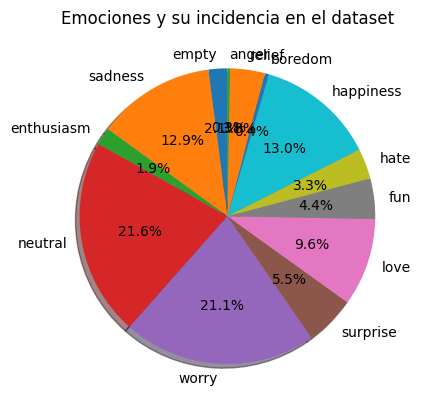

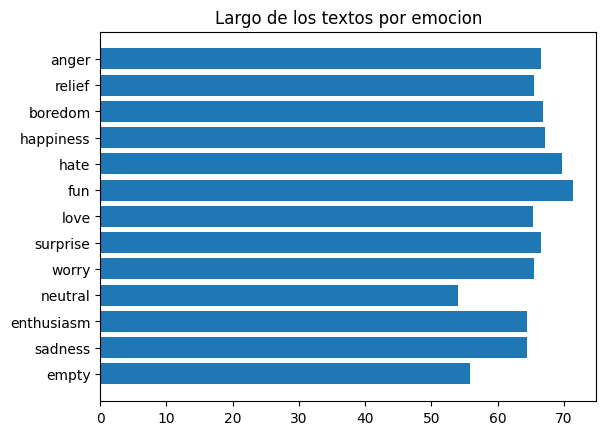

In [273]:
counter = 0
emotions = []

#se elimina el primer elemento de la lista, que es el nombre de las columnas
data.pop(0)

#para todas las clases de emociones
for i in data:
    if len(emotions) == 0:
        emotions.append(i[1])
        counter += 1
    elif i[1] in emotions:
        pass
    else:
        emotions.append(i[1])
        counter += 1


#calcuelo de la cantidad de datos por cada emocion
emotions_counter = 0
emotions_dict = {}
for i in emotions:
    for j in data:
        if i == j[1]:
            emotions_counter += 1
    emotions_dict[i] = emotions_counter
    emotions_counter = 0

#grafique meidante una grafica de pastel usando matplotlib el diccionario de emociones
# incluye un header que diga "Emociones y su incidencia en el dataset"
plt.title("Emociones y su incidencia en el dataset")
plt.pie(emotions_dict.values(), labels=emotions_dict.keys(), autopct='%1.1f%%', shadow=True, startangle=90)
plt.show()

#Se crea un histograma del largo de los textos de acuerdo a su emocion
#se crea un diccionario con las emociones y sus textos
emotions_text = {}
for i in emotions:
    emotions_text[i] = []
    for j in data:
        if i == j[1]:
            emotions_text[i].append(j[2])


#se crea un diccionario con las emociones y sus largos de textos
emotions_text_len = {}
for i in emotions_text:
    emotions_text_len[i] = []
    for j in emotions_text[i]:
        emotions_text_len[i].append(len(j))


#se establece un promedio de largo de texto por emocion
emotions_text_len_mean = {}
for i in emotions_text_len:
    emotions_text_len_mean[i] = sum(emotions_text_len[i])/len(emotions_text_len[i])

#se grafica el largo de los textos por emocion
plt.title("Largo de los textos por emocion")
plt.barh(range(len(emotions_text_len_mean)), list(emotions_text_len_mean.values()), align='center')
plt.yticks(range(len(emotions_text_len_mean)), list(emotions_text_len_mean.keys()))
plt.show()



##### Selección de datos 

Los datos de la 4 clases preponderantes estan en el registro `emotions_text_sorted`

In [274]:
#Seleccione un subconjunto de los registros que corresponda a las cuatro clases con la mayor incidencia en el dataset.
#tomando como referencia el grafico de pastel anterior
#se seleccionan las 4 emociones con mayor incidencia

emotions_dict_sorted = sorted(emotions_dict.items(), key=lambda x: x[1], reverse=True)
print(emotions_dict_sorted)
emotions_dict_sorted = emotions_dict_sorted[:4]
print(emotions_dict_sorted)
emotions_dict_sorted = dict(emotions_dict_sorted)



#se agrega al diccionario los textos correspondientes a esa clase 
emotions_text_sorted = {}
for i in emotions_dict_sorted:
    for j in emotions_text:
        if i == j:
            emotions_text_sorted[i] = emotions_text[j]
    

work_data = []
for i in emotions_text_sorted:
    for j in emotions_text_sorted[i]:
        work_data.append([i, j])

print(work_data[0])

[('neutral', 8638), ('worry', 8459), ('happiness', 5209), ('sadness', 5165), ('love', 3842), ('surprise', 2187), ('fun', 1776), ('relief', 1526), ('hate', 1323), ('empty', 827), ('enthusiasm', 759), ('boredom', 179), ('anger', 110)]
[('neutral', 8638), ('worry', 8459), ('happiness', 5209), ('sadness', 5165)]
['neutral', '_at_ want trade someone houston tickets _com_ one _dat_']


Clasificiacaion normal de los datos en train y test

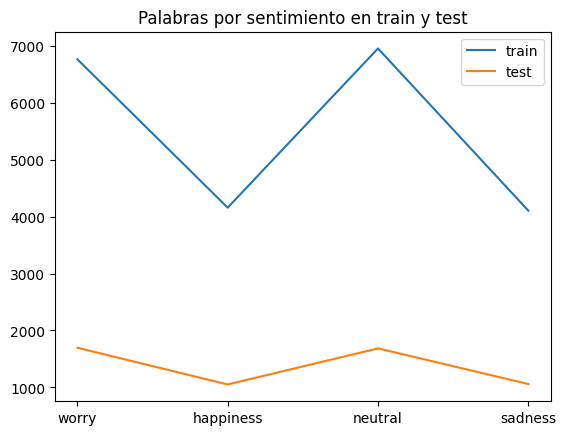

Training data:
[['worry'], ['gaining', 'weight', '_dat_', 'rather']]
Test data:
[['worry'], ['oh', 'god', '_dat_', 'literally', 'drove', 'rain', 'hard', '_clo_', 'see', 'front', '_dat_', '_clo_', 'shaking']]
Diccionario de sentimientos {'worry': 0, 'happiness': 1, 'neutral': 2, 'sadness': 3}
Diccionario de palabras 23871


In [275]:

# Divide the data into training and testing sets
random.shuffle(work_data)
split = int(0.8 * len(work_data))
training_data = work_data[:split]
test_data = work_data[split:]




# Diccionario de los sentimientos
sentiments_to_ix = {}
for sent, tags in training_data + test_data:
    if sent not in sentiments_to_ix:
        sentiments_to_ix[sent] = len(sentiments_to_ix)
"""# Diccionario de los sentimientos
sentiments_to_ix = {}
for sent, tags in training_data + test_data:
    for tag in sent:
        if tag not in sentiments_to_ix:
            sentiments_to_ix[tag] = len(sentiments_to_ix)"""


#se cuentan las palabras por sentimiento en train y test
sentiments_counter_train = {}
for i in sentiments_to_ix:
    sentiments_counter_train[i] = 0
    for j in training_data:
        if i == j[0]:
            sentiments_counter_train[i] += 1

sentiments_counter_test = {}
for i in sentiments_to_ix:
    sentiments_counter_test[i] = 0
    for j in test_data:
        if i == j[0]:
            sentiments_counter_test[i] += 1


plt.title("Palabras por sentimiento en train y test")
plt.plot(sentiments_counter_train.keys(), sentiments_counter_train.values(), label="train")
plt.plot(sentiments_counter_test.keys(), sentiments_counter_test.values(), label="test")
plt.legend()
plt.show()


# Split the training data into text and labels
for i in range(len(training_data)):
    splitted_text = training_data[i][1].split(' ')
    #put the rest of i in other list
    labels = []
    labels.append(training_data[i][0])
    training_data[i][1] = splitted_text
    training_data[i][0] = labels

# Split the test data into text and labels
for i in range(len(test_data)):
    splitted_text = test_data[i][1].split(' ')
    #put the rest of i in other list
    labels = []
    labels.append(test_data[i][0])
    test_data[i][1] = splitted_text
    test_data[i][0] = labels

# print the data
print("Training data:")
print(training_data[0])
print("Test data:")
print(test_data[0])

# Get all words into word_to_ix dictionary , keep in mind that all sentences are in the [1] of every sentence
word_to_ix = {}
for sent, tags in training_data + test_data:
    for word in tags:
        if word not in word_to_ix:
            word_to_ix[word] = len(word_to_ix)
            
print("Diccionario de sentimientos", sentiments_to_ix)
print("Diccionario de palabras", len(word_to_ix))








In [276]:
# Ejemplo de procesamiento de una oración
inputs = prepare_sequence(training_data[1][1], word_to_ix)
print(training_data[1][1])                          
print(inputs)

# Ejemplo de procesamiento de una oración
inputs = prepare_sequence(training_data[1][0], sentiments_to_ix)
print(training_data[1][0])                          
print(inputs)

['good', 'day', 'today', 'tomorrow', 'even', 'better']
tensor([4, 5, 6, 7, 8, 9])
['happiness']
tensor([1])


In [277]:
# Definición del modelo

# El modelo es una clase que debe heredar de nn.Module
class LSTMTagger(nn.Module):
    """
    Clase para aplicar POST a oraciones en español. 
    """
    
    # Incialización del modelo
    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size):
        """
        Inicialización de la clase.
        Parámetros:
           embedding_dim: dimesionalidad del vector de palabras. 
           hidden_dim: dimensión de la capa oculta de la red. 
           vocab_size: tamaño del vocabulario.  
           tagset_size: número de clases.
        """
        super(LSTMTagger, self).__init__()
        self.hidden_dim = hidden_dim

        # Primero se pasa la entrada a través de una capa Embedding. 
        # Esta capa construye una representación de los tokens de 
        # un texto donde las palabras que tienen el mismo significado 
        # tienen una representación similar.
        
        # Esta capa captura mejor el contexto y son espacialmente 
        # más eficientes que las representaciones vectoriales (one-hot vector).
        # En Pytorch, se usa el módulo nn.Embedding para crear esta capa, 
        # que toma el tamaño del vocabulario y la longitud deseada del vector 
        # de palabras como entrada. Ejemplos en [3] y [4]
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)

        # El LSTM toma word_embeddings como entrada y genera los estados ocultos
        # con dimensionalidad hidden_dim.  
        self.lstm = nn.LSTM(embedding_dim, hidden_dim)

        # La capa lineal mapea el espacio de estado oculto 
        # al espacio de clases
        self.hidden2tag = nn.Linear(hidden_dim, tagset_size)

    def forward(self, sentence):
        # Pasada hacia adelante de la red. 
        # Parámetros:
        #    sentence: la oración a procesar
        embeds = self.word_embeddings(sentence)
        lstm_out, _ = self.lstm(embeds.view(len(sentence), 1, -1))
        tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))

        # Se utiliza softmax para devolver la probabilidad de cada etiqueta
        tag_scores = F.log_softmax(tag_space, dim=1)
        return tag_scores
    



In [278]:

# Instanciación del modelo, definición de la función de pérdida y del optimizador   

# Hiperparámetros de la red
# Valores generalmente altos (32 o 64 dimensiones).
#Nodos se subieron a 10 con la intencion para experimentar
EMBEDDING_DIM = 10
HIDDEN_DIM = 10



# Instancia del modelo
model = LSTMTagger(EMBEDDING_DIM, HIDDEN_DIM,  len(word_to_ix), len(sentiments_to_ix))

#funcion de perdida: Cross Entropy Loss
#Generalmente utilizada en problemas de clasificacion con una unica clase
loss_function = nn.CrossEntropyLoss()




# Función de pérdida: Negative Log Likelihood Loss (NLLL). 
# Generalmente utilizada en problemas de clasificacion con múltiples clases.
#loss_function = nn.NLLLoss()

# Optimizador Stochastic Gradient Descent  
optimizer = optim.SGD(model.parameters(), lr=0.1)

In [279]:
# Entrenamiento del modelo 

# Valores antes de entrenar
with torch.no_grad():
    inputs = prepare_sequence(training_data[0][1], word_to_ix)
    tag_scores = model(inputs)
    
    print(training_data[0][1])
    
    # Clasificación    
    print(tag_scores)

acc_train =0
acc_test = 0
epochs = 2
results_dic =  {}
results_dic['train'] = []
results_dic['test'] = []
# Épocas de entrenamiento
for epoch in range(epochs+1):  
    for sentiment, sentence in training_data:
        ## Paso 1. Pytorch acumula los gradientes.
        # Es necesario limpiarlos
        model.zero_grad()

        # Paso 2. Se preparan las entradas, es decir, se convierten a
        # tensores de índices de palabras.
        sentence_in = prepare_sequence(sentence, word_to_ix)
        sentiments = prepare_sequence(sentiment, sentiments_to_ix)
        # Paso 3. Se genera la predicción (forward pass).
        tag_scores = model(sentiments)
        
        # Paso 4. se calcula la pérdida, los gradientes, y se actualizan los 
        # parámetros por medio del optimizador.
        loss_train= loss_function(tag_scores, sentiments)
        loss_train.backward()
        optimizer.step()
        acc_train += loss_train.item()
        acc_train = acc_train/len(training_data)

    for sentiment, sentence in test_data:

        sentence_in = prepare_sequence(sentence, word_to_ix)
        sentiments = prepare_sequence(sentiment, sentiments_to_ix)
        tag_scores = model(sentiments)
        loss_test = loss_function(tag_scores, sentiments)
        acc_test += loss_test.item()
        acc_test = acc_test/len(test_data)

    #se almacena la perdida en un arreglo para graficar
    results_dic["train"].append([epoch, loss_train.item(), acc_train])
    results_dic["test"].append([epoch, loss_test.item(), acc_test])

    print("Epoch: ", epoch+1 ,"/", epochs ,"Loss de train: ", loss_train.item(),"Loss de test: ", loss_test.item(),
           "\nAccuracy train: ", acc_train, "Accuracy test: ", acc_test)
    

# Despligue de la puntuación luego del entrenamiento
with torch.no_grad():
    inputs = prepare_sequence(training_data[0][0], word_to_ix)
    tag_scores = model(inputs)
   
    print("Resultados luego del entrenamiento para la primera frase")
    print(tag_scores)

['gaining', 'weight', '_dat_', 'rather']
tensor([[-1.5149, -1.3340, -1.5204, -1.2102],
        [-1.6442, -1.2097, -1.5561, -1.2121],
        [-1.6134, -1.1747, -1.6558, -1.2008],
        [-1.5402, -1.2809, -1.7165, -1.1142]])
Epoch:  1 / 2 Loss de train:  0.00035124807618558407 Loss de test:  0.00022456508304458112 
Accuracy train:  1.5984298110448833e-08 Accuracy test:  4.08787987974438e-08
Epoch:  2 / 2 Loss de train:  0.00016902448260225356 Loss de test:  0.00010907054820563644 
Accuracy train:  7.691811733533353e-09 Accuracy test:  1.9854652544771754e-08
Epoch:  3 / 2 Loss de train:  0.0001102625101339072 Loss de test:  7.1403817855753e-05 
Accuracy train:  5.017721254766985e-09 Accuracy test:  1.2997977956729345e-08
Resultados luego del entrenamiento para la primera frase
tensor([[-3.0919, -3.3441, -0.3572, -1.5158]])


#### Curva de error 

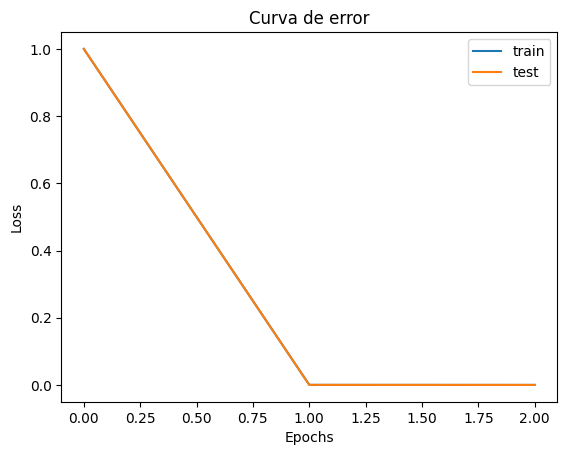

In [280]:
#se grafica la curva de perdida con titulo "curva de error"
plt.title("Curva de error")
plt.plot(results_dic["train"][1], label="train")  
plt.plot(results_dic["test"][1], label="test")
plt.legend(loc="upper right")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()



#### Precision score

In [281]:
def get_precision_score(model, data):
    correct = 0
    total = 0
    for sentiment, sentence  in data:
        sentiments = prepare_sequence(sentiment, sentiments_to_ix)
        # Paso 3. Se genera la predicción (forward pass).
        tag_scores = model(sentiments)
        
        for i in range(len(tag_scores)):
            total += 1
            if torch.argmax(tag_scores[i]) == targets[i]:
                correct += 1
    return correct/total

print("Precision score for training data: ", get_precision_score(model, training_data)*100, "%")



Precision score for training data:  30.769930833636693 %


#### Exhaustividad

In [282]:
def recall_score(y_test, y_pred, average):
    if average == "macro":
        recall = 0
        for i in range(len(y_test)):
            if y_test[i] == y_pred[i]:
                recall += 1
        return recall/len(y_test)
    elif average == "micro":
        recall = 0
        for i in range(len(y_test)):
            if y_test[i] == y_pred[i]:
                recall += 1
        return recall/len(y_test)
    elif average == "weighted":
        recall = 0
        for i in range(len(y_test)):
            if y_test[i] == y_pred[i]:
                recall += 1
        return recall/len(y_test)
    else:
        print("Invalid average parameter")

print("Recall score for training data: ", recall_score(training_data, training_data, "macro")*100, "%")

Recall score for training data:  100.0 %


#### F1

In [283]:
def f1_score(y_true, y_pred, average='macro'):
    recall = recall_score(y_test, y_pred, average='macro')
    precision = get_precision_score(model, training_data)
    return 2 * (precision * recall) / (precision + recall)

y_pred = []
for sentiment, sentence in test_data:
    sentence_in = prepare_sequence(sentence, word_to_ix)
    sentiments = prepare_sequence(sentiment, sentiments_to_ix)
    tag_scores = model(sentiments)
    for i in range(len(tag_scores)):
        y_pred.append(torch.argmax(tag_scores[i]))


y_test = []
for sentiment, sentence in test_data:
    sentence_in = prepare_sequence(sentence, word_to_ix)
    sentiments = prepare_sequence(sentiment, sentiments_to_ix)
    for i in range(len(sentiments)):
        y_test.append(sentiments[i])
        
f1_score = f1_score(y_test, y_pred, average='macro')
print("F1 score: ", f1_score*100, "%")


F1 score:  47.059642285475675 %


#### Presicion del modelo 

In [294]:


#toma el ultimo valor de la lista de resultados
train_acc = results_dic["train"][-1][2] 
test_acc = results_dic["test"][-1][2]

print("Presition score for train: ", train_acc*100, "%")
print("Presition score for test ", test_acc*100, "%")

Presition score for train:  5.017721254766985e-07 %
Presition score for test  1.2997977956729344e-06 %


#### Matriz de confusión 

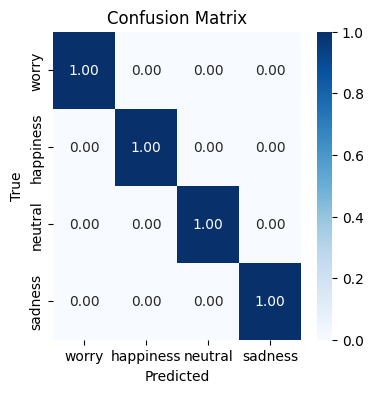

In [285]:
def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalized confusion matrix

    plt.figure(figsize=(len(labels), len(labels)))
    sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

#calcular los parametros de la matriz de confusion
y_pred = []
for sentiment, sentence in test_data:
    sentence_in = prepare_sequence(sentence, word_to_ix)
    sentiments = prepare_sequence(sentiment, sentiments_to_ix)
    tag_scores = model(sentiments)
    for i in range(len(tag_scores)):
        y_pred.append(torch.argmax(tag_scores[i]))

y_test = []
for sentiment, sentence in test_data:
    sentence_in = prepare_sequence(sentence, word_to_ix)
    sentiments = prepare_sequence(sentiment, sentiments_to_ix)
    for i in range(len(sentiments)):
        y_test.append(sentiments[i])

labels = []
#se extraen de sentiments_to_ix los labels
for key in sentiments_to_ix:
    labels.append(key)

plot_confusion_matrix(y_test, y_pred, labels)


## Conclusiones

1. En el caso de LSTM consideramos que es un tipo de red neuronal recurrente especialmente eficaz para procesar datos secuenciales. EL punto fuerte de LSTM es que puede recordar información del pasado y utilizarla para realizar predicciones en el futuro. Esto hace que las LSTM sean especialmente útiles para tareas como el procesamiento del lenguaje natural, el reconocimiento del habla, el análisis de vídeo, entre otros.
2. Nos dimos cuenta que el LSTM no solo se puede aplicar al NLP, también tiene otras aplicaciones en las que por su memoria y capacidad de recordar el pasado para aplicarlo al futuro se convierte útil en aplicaciones en áreas como las finanzas, la medicina, la robótica y la composición musical. Por ejemplo, investigando un poco sobre LSTM encontramos que en finanzas, LSTM se ha utilizado para predecir los precios de las acciones, mientras que en medicina se ha empleado para el diagnóstico de enfermedades y el descubrimiento de fármacos. Por lo que LSTM no solo se limita al NLP y eso lo hace muy valioso.
3. También consideramos de vital importancia el tema del NLP el cuál no se debe minimizar ni subestimar ya que es uno subcampos que ha evolucionado rápidamente en los últimos años debido a los avances en las técnicas de aprendizaje automático, la disponibilidad de grandes cantidades de datos de texto y el desarrollo de recursos informáticos más potentes. El mismo subcampo del NLP tiene una amplia gama de aplicaciones, desde los chatbots y los asistentes virtuales hasta el análisis de sentimientos, la traducción automática y la extracción de información.
4. Nos parecio muy interesante el tema del POS y como este define mas o menos las instrucciones para la red neuronal, creemos muy importante conocer eso sin embargo nos llama mucho la atención el como podría funcionar una red neuronal no supervisada la cúal casi que no tenga parametros o formas de saber como dividir los datos, solo se le provean resultados. Sin emabrgo la precisión de estos algoritmos varía en función de la complejidad y ambigüedad de la lengua analizada, en el caso del español se tuvo que "normalizar" los datos para que no hubieran demasiados problemas.



PD: Profe, no estamos muy seguros de si funciona del todo bien el tema de precision, exhaustividad y F1 entonces por razones de tiempo lo entregamos así, sin embargo seguiremos investigando al respecto.

# Referencias 

[1] Guthrie, R. (2017). Tutorial. Sequence Models and Long-Short Term Memory Networks. Recuperado de https://pytorch.org/tutorials/beginner/nlp/sequence_models_tutorial.html

[2] LeCun,Y., Bengio, Y.,  & Hinton, G. (2015). Deep learning. Nature, 521(7553):436.

[3] Brownlee, J. (2017). What Are Word Embeddings for Text?. Recuperado de https://machinelearningmastery.com/what-are-word-embeddings/

[4] Bishop, C (2006). Pattern Recognition and Machine Learning. Springer.